# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Основная цель проекта: обучить модель классифицировать комментарии как позитивные и негативные. Важно построить модель со значением метрики качества F1 не меньше 0.75. 

**Содержание**
<a class="anchor"  id="0"><a/>

- [Обзор и подготовка данных](#1)
  - [Обзор исходных данных](#1.1)
  - [Undersampling](#1.2)
  - [Создание эмбеддингов](#1.3)
- [Обучение моделей](#2)
  - [LogisticRegression](#2.1)
  - [RandomForest](#2.2)
  - [CatBoost](#2.3)
  - [Анализ результатов](#2.4)
- [Тестирование лучшей модели](#3)
- [Общий вывод](#4)

## Обзор и подготовка данных
<a id="1"><a/>

### Обзор исходных данных
<a id="1.1"><a/>

In [1]:
# Блок с импортами.
!pip install torch -q
!pip install transformers -q
!pip install imbalanced-learn -q
!pip install catboost -q
!pip install pymystem3 -q
!pip install wordcloud -q
#!/opt/conda/bin/python -m pip install wordcloud
#!pip install Pillow==8.0.0

import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import torch
import transformers
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaForSequenceClassification
from transformers import BertForSequenceClassification
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold
from tqdm import tqdm
from sklearn.metrics import f1_score
from pymystem3 import Mystem
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#from imblearn.pipeline import Pipeline, make_pipeline
#from imblearn.combine import SMOTETomek
#from torch.nn.utils.rnn import pad_sequence
#from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

In [2]:
# Задаём константы.
RANDOM_STATE = 42

In [3]:
# Передадим датасет в переменную и взглянем на первые пять строк.
try:
    data = pd.read_csv('C:/Users/alfer/DS_projects/toxic_comments.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Из неожиданных значений можем отметить только столбец **Unnamed: 0**. Похоже, он просто дублирует индексы.

In [4]:
# Проверим данные на наличие пропусков и соостветствие типов данных.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков нет, типы данных соответствуют ожидаемым. Попробуем изучить рандомную выборку на предмет различий между первым столбцом и индексами.

In [5]:
data.sample(20)

,Unnamed: 0,text,toxic
152949,153106,"""\n\nCfD nomination of Category:Humorous songs...",0
22170,22190,Article renaming discussion notification\n\nYo...,0
37959,38005,Then why not add volcanion & Missingno & `1 to...,0
24634,24657,"Vandalism, douching, and faggotry are not tole...",1
91541,91632,And what is your reasonable reading of the par...,0
28781,28818,"""\n\n Media protraying vandalism to wiki artic...",0
135619,135757,"""\n\n100s of Short Stories Claim\nOne of the t...",0
143134,143288,Natalie Ogle is an accomplished British Actress.,0
31839,31879,"""\n\nPlease stop. If you continue to vandalize...",0
107314,107411,Thank you for your adive and trust.,0


Значения слегка разлчаются, вероятно это результат какой-то предобработки датасета. Столбец **Unnamed: 0** не информативен, удаляем его.

In [6]:
data = data.drop('Unnamed: 0', axis=1)

Создадим облако слов и изучим общую тематику текстов в датасете.

In [7]:
# Созжаём корпусы токсичных и нетоксичных текстов.
corpus_norm = list(data[data['toxic'] == 0]['text'])
corpus_toxic = list(data[data['toxic'] == 1]['text'])

#def lemmatize(text):
 #   m = Mystem()
  #  lemm_list = m.lemmatize(text)
   # lemm_text = "".join(lemm_list)
        
    #return lemm_text

# Функция для очистки текста от лишних символов.
def clear_text(text):
    sub_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    sub_text = " ".join(sub_text.split())

    return sub_text

texts_norm = []
texts_toxic = []

# Очищаем тексты.
for i in corpus_norm:
    #lemm_i = lemmatize(i)
    clear_i = clear_text(i.lower())

    texts_norm.append(clear_i)

for i in corpus_toxic:
    #lemm_i = lemmatize(i)
    clear_i = clear_text(i.lower())

    texts_toxic.append(clear_i)

texts_norm[0]

'explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now'

In [8]:
#nltk.download('stopwords')

# Зададим список стоп-слов.
stopwords = stopwords.words("english")

In [9]:
#nltk.download('punkt')

# Создаём токены.
text_tokens_norm = word_tokenize(" ".join(texts_norm))
text_tokens_toxic = word_tokenize(" ".join(texts_toxic))

# Приводим данные к соответствующему типу.
word_list_norm = nltk.Text(text_tokens_norm)
word_list_toxic = nltk.Text(text_tokens_toxic)

# Убираем стоп-слова.
filtered_words_norm = [word for word in word_list_norm if word not in stopwords]
filtered_words_toxic = [word for word in word_list_toxic if word not in stopwords]
#filtered_words

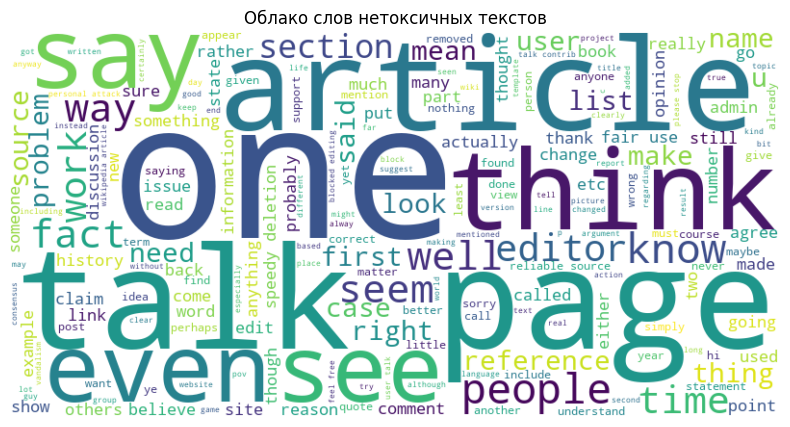

In [10]:
text_raw_norm = " ".join(filtered_words_norm)

#wordcloud = WordCloud().generate(text_raw)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_raw_norm)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Облако слов нетоксичных текстов")
plt.show()

Можем отметить массу слов из типичной разговорной лексики. Слова article, page, editor, source, reference, reliable source вероятно указывают на редакторскую деятельность, перепроверку фактов, краудсорсинг.

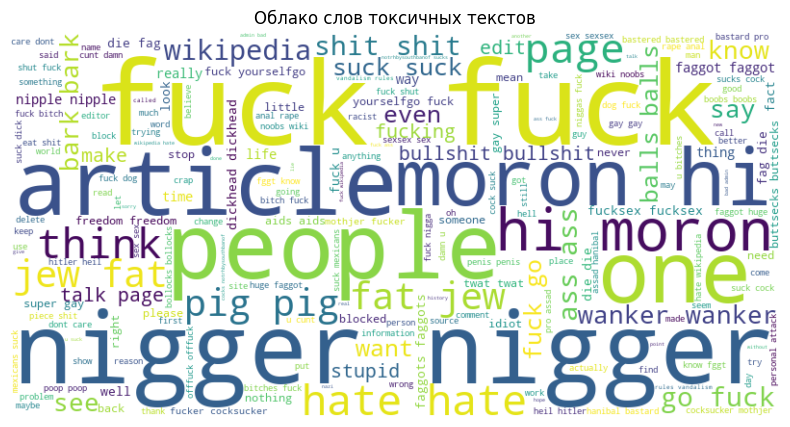

In [11]:
text_raw_toxic = " ".join(filtered_words_toxic)

#wordcloud = WordCloud().generate(text_raw)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_raw_toxic)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Облако слов токсичных текстов")
plt.show()

Что ж (͡° ͜ʖ ͡°)

Среди всего многообразия выражений можем  отметить слова article, page, talk page, wikipedia. Токсичные и нетоксичные тексты явно связаны, общая тематика для нашей задачи подходящая.

[Назад к содержанию](#0)

### Дисбаланс классов
<a id="1.2"><a/>

Изучим целевой признак на предмет дисбаланса классов. 

In [12]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Нетоксичных текстов в датасете почти в девять раз больше, чем токсичных. Учтём это при инициализации моделей.

In [13]:
# Отделяем таргет от входных данных. Тексты очистим от лишних символов.
data_sample = data.sample(frac=0.15, random_state=RANDOM_STATE)
X = data_sample.iloc[:,0:1]
X = X['text'].apply(clear_text)
y = data_sample['toxic']
X

31015     Sometime back I just happened to log on to www...
102832    The latest edit is much better don t make this...
67317     October UTC I would think you d be able to get...
81091     Thanks for the tip on the currency translation...
90091     I would argue that if content on the Con in co...
                                ...                        
120613    Lion again G day Uther hoping you have some ti...
87089     He also exaggerates claiming that my edits are...
130840    You are making things up a syou go along I hav...
139992    The problem is that our dispute over the illus...
111260    This is the end for me I will never forget or ...
Name: text, Length: 23894, dtype: object

[Назад к содержанию](#0)

### Создание эмбеддингов
<a id="1.3"><a/>

In [15]:
# Загружаем предобученный BERT
tokenizer = BertTokenizer.from_pretrained("unitary/toxic-bert")

bert_model = BertModel.from_pretrained("unitary/toxic-bert")    

bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [17]:
#X_resample_list = list(X['text'])
X_resample_list = list(X)
y_resample_list = list(y)

In [18]:
# Разделяем на тренировочную и тестовую выборку (20% для теста)
X_train, X_test, y_train, y_test = train_test_split(X_resample_list, y_resample_list, test_size=0.2, random_state=42)

In [19]:
# Функция для создания эмбеддингов BERT
def get_bert_embeddings(texts, batch_size=16, max_length=128):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        encoding = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask)
        # Берем [CLS] токен в качестве эмбеддинга предложения
        batch_embeddings = outputs.last_hidden_state[:,0,:].numpy()
        #batch_embeddings = outputs[0][0,:].numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [20]:
# Получаем эмбеддинги для тренировочных и тестовых данных
X_train_vec = get_bert_embeddings(X_train)
X_test_vec = get_bert_embeddings(X_test)

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [03:54<00:00,  1.27it/s]


**Итоги подготовки данных:**

- Удалён столбец **Unnamed: 0**.
- Проведена процедура андерсэмплинга. Количество значений мажорного класса (нетоксичные комментарии) приравнено к количеству данных минорного (токсичные комментарии).
- Предобученный BERT использован для получения эмбеддингов. 

[Назад к содержанию](#0)

## Обучение моделей
<a id="2"><a/>

### LogisticRegression
<a id="2.1"><a/>

In [33]:
# Обучаем логистическую регрессию
model = LogisticRegression(max_iter=1000, class_weight='balanced')

params = {'C': range(1, 10)}

logistic_model = RandomizedSearchCV(
    model,
    params,
    scoring='f1',
    n_jobs=-1,
    n_iter=5,
    cv=3,
    verbose=5,
    random_state=RANDOM_STATE,
)

logistic_model.fit(X_train_vec, y_train)

cv_f1_logistic = logistic_model.best_score_
logistic_train_time = logistic_model.cv_results_['mean_fit_time'][logistic_model.best_index_]

print('Лучшая модель: \n', logistic_model.best_estimator_)
print('f1 на кросс-валидации:', cv_f1_logistic)
print('Среднее время обучения модели:', logistic_train_time, 'cекунд')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшая модель: 
 LogisticRegression(C=1, class_weight='balanced', max_iter=1000)
f1 на кросс-валидации: 0.889274338274037
Среднее время обучения модели: 9.495832840601603 cекунд


[Назад к содержанию](#0)

### RandomForest
<a id="2.2"><a/>

In [26]:
# Обучаем модель случайного леса
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

params = {
    'max_depth': range(1, 20),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 6),
    'n_estimators': range(10, 50)
}

random_forest_model = RandomizedSearchCV(
    rf_model,
    params,
    scoring='f1',
    n_jobs=-1,
    n_iter=5,
    cv=5,
    verbose=5,
    random_state=RANDOM_STATE,
)

random_forest_model.fit(X_train_vec, y_train)

cv_f1_random_forest = random_forest_model.best_score_
random_forest_train_time = random_forest_model.cv_results_['mean_fit_time'][random_forest_model.best_index_]

print('Лучшая модель: \n', random_forest_model.best_estimator_)
print('f1 на кросс-валидации:', cv_f1_random_forest)
print('Среднее время обучения модели:', random_forest_train_time, 'cекунд')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшая модель: 
 RandomForestClassifier(class_weight='balanced', max_depth=17,
                       min_samples_leaf=4, min_samples_split=5, n_estimators=28,
                       random_state=42)
f1 на кросс-валидации: 0.9138714476104024
Среднее время обучения модели: 9.164213705062867 cекунд


### CatBoost
<a id="2.3"><a/>

In [29]:
catboost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

In [30]:
# Обучаем модель градиентного бустинга
params = {}

catboost_model = RandomizedSearchCV(
    catboost,
    params,
    scoring='f1',
    n_jobs=-1,
    n_iter=5,
    cv=3,
    verbose=5,
    random_state=RANDOM_STATE,
)

catboost_model.fit(X_train_vec, y_train)

cv_f1_catboost = catboost_model.best_score_
catboost_train_time = catboost_model.cv_results_['mean_fit_time'][catboost_model.best_index_]

print('f1 на кросс-валидации:', cv_f1_catboost)
print('Среднее время обучения модели:', catboost_train_time, 'cекунд')

C:\Users\alfer\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
f1 на кросс-валидации: 0.9187129290314258
Среднее время обучения модели: 123.75585714975993 cекунд


[Назад к содержанию](#0)

### Анализ результатов
<a id="2.4"><a/>

Соберём в таблицу результаты обучения и выберем лучшую модель.

In [34]:
results = {
    'model': ['LogisticRegression', 'RandomForest', 'CatBoost'],
    'train_time (seconds)': [logistic_train_time, random_forest_train_time, catboost_train_time],
    'cv_f1': [cv_f1_logistic, cv_f1_random_forest, cv_f1_catboost]
}

models = pd.DataFrame(results)
models

,model,train_time (seconds),cv_f1
0,LogisticRegression,9.495833,0.889274
1,RandomForest,9.164214,0.913871
2,CatBoost,123.755857,0.918713


Все модели преодолели порог качества на кросс-валидации. Модель градиентного бустинга незначительно лучше модели случайного леса, но вторая заметно быстрее. Для тестирования выберем случайный лес.

[Назад к содержанию](#0)

## Тестирование лучшей модели
<a id="3"><a/>

In [35]:
# Создаём предсказания и тестируем модель.
y_pred = random_forest_model.predict(X_test_vec)
print('F1 лучшей модели на тестовой выборке:', f1_score(y_test, y_pred))

F1 лучшей модели на тестовой выборке: 0.9193548387096774


## Общий вывод

Интернет-магазином «Викишоп» поставлена задача: обучить модель классифицировать комментарии как позитивные и негативные. Важно построить модель со значением метрики качества F1 не меньше 0.75.

Для решения задачи проделаны следующие шаги:

**Подготовка данных**

На данном этапе:

- Удалён столбец **Unnamed: 0**.
- Проведена процедура андерсэмплинга. Количество значений мажорного класса (нетоксичные комментарии) приравнено к количеству данных минорного (токсичные комментарии).
- Предобученный BERT использован для получения эмбеддингов.

**Обучение моделей**

Были обучены следующие модели:

**LogisticRegression**

- f1 на кросс-валидации: 0.889274338274037
- Среднее время обучения модели: 9.495832840601603 cекунд

**RandomForest**

Гиперпараметры лучшей модели:

- class_weight='balanced'
-  max_depth=17
-  min_samples_leaf=4
-  min_samples_split=5
-  n_estimators=28
-  random_state=42


- f1 на кросс-валидации: 0.9138714476104024
- Среднее время обучения модели: 9.164213705062867 cекунд

**CatBoost**

- f1 на кросс-валидации: 0.9187129290314258
- Среднее время обучения модели: 123.75585714975993 cекунд

Все модели преодолели порог качества на кросс-валидации. 

Модель градиентного бустинга незначительно лучше модели случайного леса, но вторая заметно быстрее. Для тестирования выберем случайный лес.

F1 лучшей модели на тестовой выборке: 0.9193548387096774